# English Data Notebook

## Import Libraries

In [2]:
import json
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (f1_score, accuracy_score, recall_score,
                             precision_score, confusion_matrix, classification_report)
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import dump

## Import Datasets
from Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
trainset_json = '/content/drive/My Drive/Thesis/Trainset/ML-ESG-3_Trainset_English.json'
testset_json = '/content/drive/My Drive/Thesis/Testset/ML-ESG3_Testset_EN.json'

Convert JSON files to dataframes

In [5]:
with open(trainset_json, 'r') as file:
    train_json_data = json.load(file)

with open(testset_json, 'r') as file:
    test_json_data = json.load(file)

train_df = pd.json_normalize(train_json_data)
test_df = pd.json_normalize(test_json_data)

## Exploratory Data Analysis

In [6]:
train_df.head()

,URL,news_title,news_content,impact_level,impact_length
0,https://www.esgtoday.com/arabesque-ai-appoints...,Arabesque AI Appoints Carolina Minio Paluello ...,ESG-focused financial technology company Arabe...,low,2 to 5 years
1,https://www.esgtoday.com/arabesque-ai-appoints...,Arabesque AI Appoints Carolina Minio Paluello ...,The company also announced the appointment of ...,low,2 to 5 years
2,https://www.esgtoday.com/arabesque-ai-appoints...,Arabesque AI Appoints Carolina Minio Paluello ...,Wong said: \n“Personalised portfolios demand ...,medium,2 to 5 years
3,https://www.esgtoday.com/ukraine-war-inflation...,"Ukraine War, Inflation Reduction Act Driving F...",One of the key themes of the report is the imp...,high,More than 5 years
4,https://www.esgtoday.com/eu-regulators-welcome...,"EU Regulators Welcome, Critique New European S...",Europe’s three primary financial regulatory ag...,medium,Less than 2 years


In [7]:
print(f"Shape of the trainset: {train_df.shape}")
print(f"Shape of the testset: {test_df.shape}")

Shape of the trainset: (545, 5)
Shape of the testset: (136, 5)


In [8]:
display(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   URL            545 non-null    object
 1   news_title     545 non-null    object
 2   news_content   545 non-null    object
 3   impact_level   545 non-null    object
 4   impact_length  545 non-null    object
dtypes: object(5)
memory usage: 21.4+ KB


None

In [9]:
print(train_df.nunique())

URL              339
news_title       339
news_content     545
impact_level       3
impact_length      3
dtype: int64


From the above results we can observe that two features that are categorical, because they have only three unique values. Let's focus on these to features and make some insights.

In [10]:
print("Below are the categorical values of impact_level")
train_df['impact_level'].unique()

Below are the categorical values of impact_level


array(['low', 'medium', 'high'], dtype=object)

In [11]:
print("Below are the categorical values of impact_length")
train_df['impact_length'].unique()

Below are the categorical values of impact_length


array(['2 to 5 years', 'More than 5 years', 'Less than 2 years'],
      dtype=object)

In [12]:
fig = px.histogram(train_df, x='impact_level', nbins=30, marginal='rug', title='Distribution of Impact Level')
fig.update_layout(xaxis_title='impact_level', yaxis_title='Frequency')
fig.show()

Our dataset for impact level classification demonstrates a moderate imbalance. The distribution of classes is as follows: low (106), medium (243), and high (196), which translates to approximately 25%, 57%, and 18% of the total samples, respectively.

In this context, the "low" class is the minority class, which may present challenges during model training, particularly if the model tends to favor the majority class. Conversely, the "medium" class serves as the majority, offering the model a substantial amount of data to learn from. This imbalance highlights the need for careful consideration in our modeling approach to ensure effective classification across all classes.

In [13]:
fig = px.histogram(train_df, x='impact_length', nbins=30, marginal='rug', title='Distribution of Impact Length')
fig.update_layout(xaxis_title='impact_length', yaxis_title='Frequency')
fig.show()

Our dataset for impact length classification exhibits a moderate imbalance. The distribution of classes is as follows: less than 2 years (82), 2 to 5 years (198), and more than 5 years (265), which corresponds to approximately 19%, 46%, and 35% of the total samples, respectively.

In this case, the "less than 2 years" class is the minority, which may pose challenges during model training, especially if the model tends to favor the majority classes. Meanwhile, the "more than 5 years" class represents the majority, providing the model with a robust amount of data to learn from. This imbalance underscores the importance of adopting careful strategies in our modeling approach to ensure effective classification across all classes.



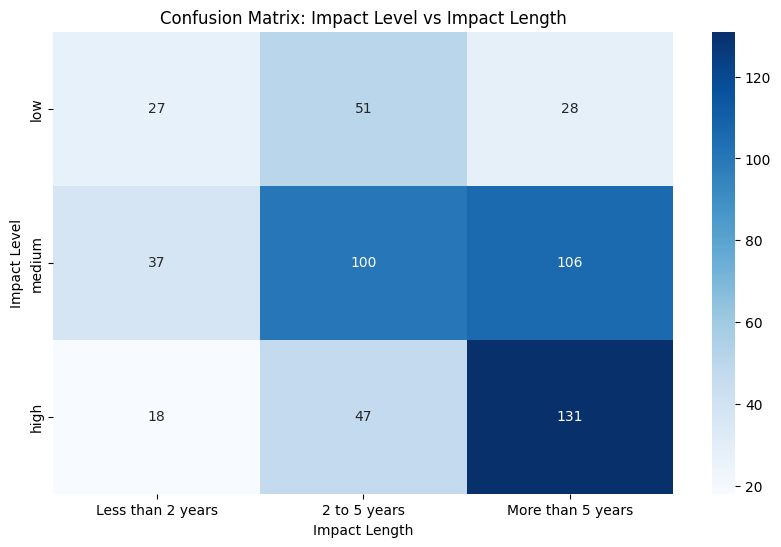

In [14]:
train_df['impact_length'] = pd.Categorical(
    train_df['impact_length'],
    categories=['Less than 2 years', '2 to 5 years', 'More than 5 years'],
    ordered=True
)

train_df['impact_level'] = pd.Categorical(
    train_df['impact_level'],
    categories=['low', 'medium', 'high'],
    ordered=True
)

conf_matrix = pd.crosstab(train_df['impact_level'], train_df['impact_length'], rownames=['Impact Level'], colnames=['Impact Length'])
plt.figure(figsize=(10,6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix: Impact Level vs Impact Length')
plt.show()

From the above confusion matrix we can observe many things. Firstly, we can see that most cases are associated with "More than 5 years" as we have 131+106+28=265 cases. The data shows that high-impact projects are usually longer, especially those lasting "More than 5 years", indicating that longer projects often have a greater impact. Medium-impact projects are spread fairly evenly across different durations, suggesting that time doesn't heavily influence their impact level. On the other hand, low-impact projects tend to be shorter, with most lasting "2 to 5 years" or "less than 2 years", and fewer extending "More than 5 years".

<ipython-input-15-587c5fccf333>:26: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



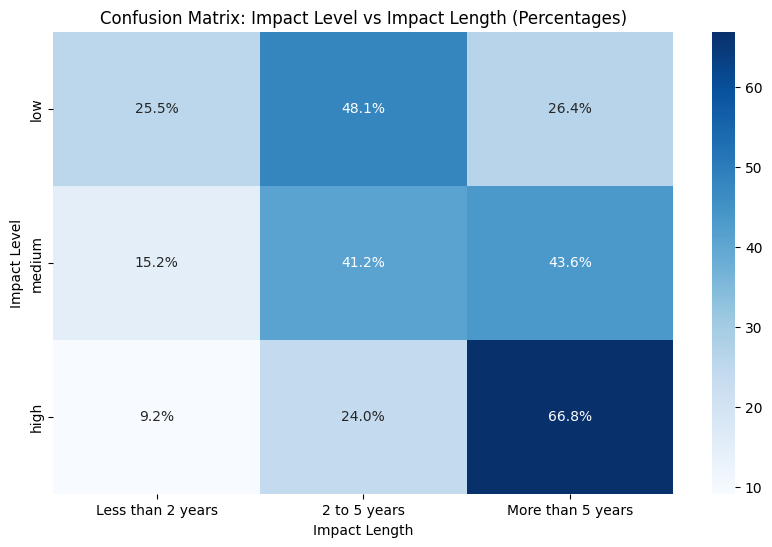

In [15]:
train_df['impact_length'] = pd.Categorical(
    train_df['impact_length'],
    categories=['Less than 2 years', '2 to 5 years', 'More than 5 years'],
    ordered=True
)

# Ensure the 'impact_level' column is ordered as a categorical variable with correct order
train_df['impact_level'] = pd.Categorical(
    train_df['impact_level'],
    categories=['low', 'medium', 'high'],
    ordered=True
)

# Create the confusion matrix
conf_matrix = pd.crosstab(train_df['impact_level'], train_df['impact_length'], rownames=['Impact Level'], colnames=['Impact Length'])

# Calculate percentages
conf_matrix_percent = conf_matrix.apply(lambda r: r / r.sum() * 100, axis=1)  # Row-wise percentage

# Add row and column sums to the original matrix
conf_matrix_with_totals = conf_matrix.copy()
conf_matrix_with_totals.loc['Total'] = conf_matrix.sum(axis=0)  # Column totals
conf_matrix_with_totals['Total'] = pd.concat([conf_matrix.sum(axis=1), pd.Series(conf_matrix.sum().sum(), index=['Total'])])  # Row totals

# Prepare the text for the annotations (percentages)
annot = conf_matrix_percent.applymap(lambda x: '{:.1f}%'.format(x))

# Plot the confusion matrix with percentages
plt.figure(figsize=(10,6))
sns.heatmap(conf_matrix_percent, annot=annot, fmt='', cmap='Blues')  # Display percentages
plt.title('Confusion Matrix: Impact Level vs Impact Length (Percentages)')
plt.show()

## Encoding Categorical Features
In this part the categorical features will be encoded in order to have more effective dataset.

In [16]:
train_df["impact_level"] = train_df["impact_level"].replace(["low","medium","high"],[0,1,2])
train_df["impact_length"] = train_df["impact_length"].replace(["Less than 2 years","2 to 5 years","More than 5 years"],[0,1,2])
test_df["impact_level"] = test_df["impact_level"].replace(["low","medium","high"],[0,1,2])
test_df["impact_length"] = test_df["impact_length"].replace(["Less than 2 years","2 to 5 years","More than 5 years"],[0,1,2])

train_df

<ipython-input-16-d9efbd076fbd>:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-16-d9efbd076fbd>:1: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.

<ipython-input-16-d9efbd076fbd>:2: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-16-d9efbd076fbd>:2: FutureWarning:

The behavior of Series.repl

,URL,news_title,news_content,impact_level,impact_length
0,https://www.esgtoday.com/arabesque-ai-appoints...,Arabesque AI Appoints Carolina Minio Paluello ...,ESG-focused financial technology company Arabe...,0,1
1,https://www.esgtoday.com/arabesque-ai-appoints...,Arabesque AI Appoints Carolina Minio Paluello ...,The company also announced the appointment of ...,0,1
2,https://www.esgtoday.com/arabesque-ai-appoints...,Arabesque AI Appoints Carolina Minio Paluello ...,Wong said: \n“Personalised portfolios demand ...,1,1
3,https://www.esgtoday.com/ukraine-war-inflation...,"Ukraine War, Inflation Reduction Act Driving F...",One of the key themes of the report is the imp...,2,2
4,https://www.esgtoday.com/eu-regulators-welcome...,"EU Regulators Welcome, Critique New European S...",Europe’s three primary financial regulatory ag...,1,0
...,...,...,...,...,...
540,https://www.esgtoday.com/methane-emissions-det...,Methane Emissions Detection Platform Kuva Rais...,"Stefan Bokaemper, CEO of Kuva Systems, said: “...",0,1
541,https://www.esgtoday.com/eaton-appoints-harold...,Eaton Appoints Harold Jones as Chief Sustainab...,Eaton Appoints Harold Jones as Chief Sustainab...,0,1
542,https://www.esgtoday.com/ssga-outlines-2021-st...,"SSGA Outlines 2021 Stewardship Priorities, Wil...","In his letter, Taraporevala wrote: “As a signa...",1,0
543,https://www.esgtoday.com/survey-investors-shif...,Survey: Investors Shifting to Offense on Clima...,O’Brien said: “Investors globally are increasi...,0,0


In [18]:
print(train_df['URL'].nunique())

339


It can be observed that there are 339 unique URLs out of a total of 545 in the dataset. This indicates that there are 206 duplicate URLs, suggesting that the content and titles were extracted from the same URL page.